### Paquetes empleados para el desarrollo de la modelación con julia de Redes convolucionales

In [148]:
using Pkg
# Pkg.add("Flux")
Pkg.add(Pkg.PackageSpec(;name="Flux", version="0.9.0"))
Pkg.add("BSON")
Pkg.add("ImagenView")
Pkg.add("Plots")
Pkg.add("ImageIO")
Pkg.add("ImageMagick")
Pkg.add("Tracker")
Pkg.add("Images")
Pkg.add("FileIO")

   Updating registry at `~/.julia/registries/General`
--2021-02-08 17:02:06--  https://pkg.julialang.org/registry/23338594-aafe-5451-b93e-139f81909106/54662d38fc61a7d9de148125e91e907e29b36302
Resolving pkg.julialang.org (pkg.julialang.org)... 2a04:4e42:c::729, 151.101.50.217
Connecting to pkg.julialang.org (pkg.julialang.org)|2a04:4e42:c::729|:443... connected.
HTTP request sent, awaiting response... 301 ipv6 us-east internal redirect trigger
Location: https://us-east.pkg.julialang.org/registry/23338594-aafe-5451-b93e-139f81909106/54662d38fc61a7d9de148125e91e907e29b36302 [following]
--2021-02-08 17:02:06--  https://us-east.pkg.julialang.org/registry/23338594-aafe-5451-b93e-139f81909106/54662d38fc61a7d9de148125e91e907e29b36302
Resolving us-east.pkg.julialang.org (us-east.pkg.julialang.org)... 2600:1f18:18bc:3800:8d39:de54:21e4:22d5, 54.144.24.222
Connecting to us-east.pkg.julialang.org (us-east.pkg.julialang.org)|2600:1f18:18bc:3800:8d39:de54:21e4:22d5|:443... connected.
HTTP request se

LoadError: The following package names could not be resolved:
 * ImagenView (not found in project, manifest or registry)


In [70]:
; pwd #Validación de en que carpeta nos encontramos

/home/arteck/Documents/P/maestria/tareas/1_semestre/Programación Avanzada


In [71]:
; git clone https://github.com/INVASIS/Viola-Jones ## utilizamos este repo para cargar las fotos de cara, no cara

fatal: destination path 'Viola-Jones' already exists and is not an empty directory.


In [72]:
; ls # Validamos que se creo la carpeta "Viola-Jones"

RCN.ipynb
RCN_orden_aleatorio.ipynb
RCN_sin_desordenar.ipynb
Viola-Jones
yalefaces


In [73]:
using Flux, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated, partition
using Printf, BSON
using ImageView
using Plots
using Tracker
##Use 
using Images, FileIO
using Random: shuffle



In [79]:
@time begin
    files_faces_train = readdir("Viola-Jones/data/trainset/faces/")  # Se obtienen las imagenes de caras para el entrenamiento
    images_train = Array{Array{Gray{Normed{UInt8,8}},2},1}() # Se crea un arreglo que permita almacenar las imagens normalizadas y en escala de grises para el entrenamiento
    for file in files_faces_train # Recorremos el arreglo con las imágenes precentes en files_faces_train
        img_path = "Viola-Jones/data/trainset/faces/" * file # Se crea el path de la imágen a cargar
        img_temp = load(img_path) # Se carga la imagen
        push!(images_train, img_temp)    #Se agrega la imagen a images_train
    end
end
y_train=ones(size(files_faces_train)) #Arreglo con la etiqueta de face = 1, no face = 0, iniciando con las imagenes de face, es decir, 1
@time begin
    files_no_faces_train = readdir("Viola-Jones/data/trainset/non-faces/") # Se obtienen las imagenes de no caras para el entrenamiento
    for file in files_no_faces_train # Recorremos el arreglo con las imágenes precentes en files_no_faces_train
        img_path = "Viola-Jones/data/trainset/non-faces/" * file # Se crea el path de la imágen a cargar
        img_temp = load(img_path) # Se carga la imagen
        push!(images_train, img_temp)    #Se agrega la imagen a images_train
    end
end
y_train = vcat(y_train, zeros(size(files_no_faces_train))) #Agregar los datos de las no faces, es decir, 0

  0.240639 seconds (628.63 k allocations: 33.522 MiB)
  0.816508 seconds (2.21 M allocations: 118.425 MiB, 1.94% gc time)


10977-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [80]:
@time begin
    files_faces_test = readdir("Viola-Jones/data/testset/faces/") # Se obtienen las imagenes de caras para la validación
    images_test = Array{Array{Gray{Normed{UInt8,8}},2},1}() # Se crea un arreglo que permita almacenar las imagens normalizadas y en escala de grises para la validación
    for file in files_faces_test # Recorremos el arreglo con las imágenes precentes en files_faces_test
        img_path = "Viola-Jones/data/testset/faces/" * file # Se crea el path de la imágen a cargar
        img_temp = load(img_path) # Se carga la imagen
        push!(images_test, img_temp)     #Se agrega la imagen a images_test
    end
end
y_test=ones(size(files_faces_test)) #Arreglo con la etiqueta de face = 1, no face = 0, iniciando con las imagenes de face, es decir, 1
@time begin
    files_no_faces_test = readdir("Viola-Jones/data/testset/non-faces/") # Se obtienen las imagenes de no caras para la validación
    for file in files_no_faces_test # Recorremos el arreglo con las imágenes precentes en files_no_faces_test
        img_path = "Viola-Jones/data/testset/non-faces/" * file # Se crea el path de la imágen a cargar
        img_temp = load(img_path) # Se carga la imagen
        push!(images_test, img_temp)     #Se agrega la imagen a images_test
    end
end
y_test = vcat(y_test, zeros(size(files_no_faces_test))) #Agregar los datos de las no faces, es decir, 0

  0.049838 seconds (121.80 k allocations: 6.501 MiB)
  1.905780 seconds (5.07 M allocations: 270.585 MiB, 2.56% gc time)


20044-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [84]:
index =shuffle(1: length(y_train)) ## En el notebook RCN_sin_desordenar.ipynb se incluian las imagenes
### sin un nuevo ordenamiento aleatorio, para que el batch que se cree contenga caras y no caras

10977-element Array{Int64,1}:
  1126
  1829
  8488
 10532
  7384
  9500
  8028
  2006
  1552
  7445
  4026
  6019
  8898
     ⋮
   375
  5868
  3937
  7487
  5667
  3535
  5246
  3669
  5783
  6939
  6051
  5311

In [85]:
### Se crean las variables necesarias para seguir el tutorial de https://towardsdatascience.com/a-primer-on-computer-vision-with-julia-2c7068a35b32
train_labels = gpu.(y_train[index])
train_imgs = gpu.(images_train[index]);


In [105]:
### para el test
test_imgs = images_test
test_labels = y_test


20044-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [150]:

print("El tamaño de dataset de entrenamiento es de: $(size(train_imgs)) \n")
print("El tamaño de dataset de validación es de: $(size(test_imgs))")


El tamaño de dataset de entrenamiento es de: (10977,) 
El tamaño de dataset de validación es de: (20044,)

In [89]:
size(train_imgs[1])

(19, 19)

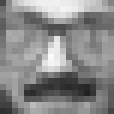

In [151]:

# Se vizualiza una imagen de 19 x 19 pixeles
NROWS, NCOLS = 19, 19
a = reshape(train_imgs[1], NROWS, NCOLS)

In [152]:
800/32

25.0

In [93]:
model = Chain(
    
    #Primera convoluciona, recibe un canal (1 => 16) y crea diferentes resultados de la imagen
    #Aplicando un filtro de 3x3, se considera un zero padding de 2, es decir a los pixeles, se le agrega
    ## 2 pixiles de 0 para lograr incorporar inforamción de las orillas de la imange, la función de
    ## Activación es Relu, es un rectificador lineal que ayuda a quitar la linealidad
    ## de entrenaer el modelo esto se repetirá en la capa siguiente
    Conv((3, 3), 1=>16, pad=(2,2), relu),
    MaxPool((2,2)), #maxpooling
    ## Para reducir el tamaño de las matrices finales de utilza un muestro, en este caso, cada cuatro 
    ## Pixeles se seleccionará el máximo (maxpolling)

    # Se repite el caso anterior, pero en esta ocación el número de canales de entrada es de 16,
    # y el zero padding sólo considera 1 pixel extra, se utiliza de nuevo la función de activación 
    # Relu
    Conv((3, 3), 16=>32, pad=(1,1), relu),
    MaxPool((2,2)), #maxpooling

    # En el tutorial seguido sugieren agregar otra capa de convolución, por ser de pixeles 
#     Conv((3, 3), 32=>32,pad=(1,1), relu),
#     MaxPool((2,2)),
    # Hasta este punto tenemos un arreglo de (5,5,32, 2)
    #Entonces se hace un reshape de la salida con una capa de salida (Dense)
    #la cual tendrá una entra de 800 y salida de 2
    x -> reshape(x, :, size(x, 4)),
    
    Dense(800, 2),
    # Se agrega una capa softmax para obtener las probabilidades
    softmax,
)

model = gpu(model); # Flux nos permite cargar el modelo en gpu en caso de contar con 
# hardware y controladores necesarios

In [109]:
# Batching 
# See: https://github.com/FluxML/model-zoo/blob/master/vision/mnist/conv.jl
# Bundle images together with labels and group into minibatchess
function make_minibatch(X, Y, idxs)
    ### Se usa la sigueinte función para crear los barch que se usarán en el entrenamiento del modelo
    X_batch = Array{Float32}(undef, size(X[1])..., 1, length(idxs))
    for i in 1:length(idxs)
        X_batch[:, :, :, i] = Float32.(X[idxs[i]])
    end
    #onehotbatch permite crear un encoder que es válido para la red neuronal convoluconal
    Y_batch = onehotbatch(Y[idxs], 0:1)
    return (X_batch, Y_batch)
end
# La red sólo verá 128 imágenes a la vez:
batch_size = 128
# Se crea una partición con 128 elementos en cada Pi
mb_idxs = partition(1:length(train_imgs), batch_size)
# Se desconpone train_imgs para que contenga minibatch de 128
train_set = [make_minibatch(train_imgs, train_labels, i) for i in mb_idxs];
# de tiene el resultado pero para toda la información de train
train_set_full = make_minibatch(train_imgs, train_labels, 1:length(train_imgs));
# Se desconpone test_imgs para que contenga minibatch de 128
test_set = make_minibatch(test_imgs, test_labels, 1:length(test_imgs));

In [113]:
Creamos la función de perdida
function loss(x, y)
    ## Se agrega un poco de ruido a la imagen para evitar sobre ajuste
    x_aug = x .+ 0.1f0*gpu(randn(eltype(x), size(x)))

    y_hat = model(x_aug)
    # Se calcula la función de pérdida usando crossentropy
    return crossentropy(y_hat, y)
end
accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))

# El optimizador que se usa para entrenar la red es ADAM
opt = ADAM(0.001);

In [115]:
# Training loop
# See: https://github.com/FluxML/model-zoo/blob/master/vision/mnist/conv.jl
best_acc = 0.0
last_improvement = 0
accuracy_target = 0.97 #Set an accuracy target. When reached, we stop training.
max_epochs = 100 #Máximas iteraciones
for epoch_idx in 1:100
    
    global best_acc, last_improvement
    # Entrenamiento para un sólo batch
    Flux.train!(loss, params(model), train_set, opt)

    # Calculo de la exactitud
    acc = accuracy(train_set_full...)
    @info(@sprintf("[%d]: Train accuracy: %.4f", epoch_idx, acc))
    
    # Calculo de la exactitud
    acc = accuracy(test_set...)
    @info(@sprintf("[%d]: Test accuracy: %.4f", epoch_idx, acc))

    # En caso de tener una exactitud mayor a la de accuracy_target se sale del ciclo
    if acc >= accuracy_target
        @info(" -> Early-exiting: We reached our target accuracy of $(accuracy_target*100)%")
        break
    end

    # En caso de tener una exactitud mayor a la de accuracy_target se sale del ciclo
    if epoch_idx - last_improvement >= 10
        @warn(" -> We're calling this converged.")
        break
    end
end

┌ Info: [1]: Train accuracy: 0.9818
└ @ Main In[115]:14
┌ Info: [1]: Test accuracy: 0.9730
└ @ Main In[115]:18
┌ Info:  -> Early-exiting: We reached our target accuracy of 97.0%
└ @ Main In[115]:22


In [116]:
# Get predictions and convert data to Array: 
pred = Tracker.data(model(test_set[1])); 

# Function to get the row index of the max value: 
f1(x) = getindex.(argmax(x, dims=1), 1) # Final predicted value is the one with the maximum probability: 
pred = f1(pred) .- 1; #minus 1, because the first digit is 0 (not 1)
pred

1×20044 Array{Int64,2}:
 0  1  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0

### Métricas de desempeño

In [153]:
true_positives = sum((y_test .== transpose(pred)) .& (y_test .== 1))

75

In [154]:
true_negatives = sum((y_test .== transpose(pred)) .& (y_test .== 0))

19428

In [155]:
false_positives = sum((y_test .!= transpose(pred)) .& (y_test .== 1))

397

In [156]:
false_negatives = sum((y_test .!= transpose(pred)) .& (y_test .== 0))

144

### Métricas

In [157]:
acurracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

0.3424657534246575

In [158]:
print("La exactitud del modelo fue: $(acurracy)\n")
print("La precisión del modelo fue: $(precision)\n")
print("El recall del modelo fue: $(recall)\n")

La exactitud del modelo fue: 0.9730093793653961
La precisión del modelo fue: 0.15889830508474576
El recall del modelo fue: 0.3424657534246575


# Bibliografía

In [ ]:
https://www.juanbarrios.com/redes-neurales-convolucionales/#:~:text=Capa%20De%20Convoluci%C3%B3n%3A%20procesar%C3%A1%20la,en%20el%20volumen%20de%20entrada.
https://medium.com/@jayeshbahire/cnn-implementation-using-julia-defe90d86eb2